In [ ]:
#| default_exp ocr_paligemma

In [ ]:
#| export

from __future__ import annotations


In [ ]:
#| hide
# %reload_ext autoreload
# %autoreload 0


# Testing `PaliGemma` OCR for Comics
> Accuracy Enhancements for OCR in `PanelCleaner`


# Prologue

In [ ]:
#| export
import subprocess
from pathlib import Path
from typing import Any
from typing import Literal
from typing import TypeAlias

import torch
import transformers.image_utils as image_utils
from PIL import Image
from rich.console import Console
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
from transformers import PaliGemmaForConditionalGeneration


In [ ]:
import os
import re
import sys
from typing import cast
import requests

import fastcore.all as FC
import fastcore.xtras  # patch pathlib.Path with some utils
import transformers
from fastcore.test import *  # type: ignore


need version >4.41 of transformers

In [ ]:
transformers.__version__

'4.42.0.dev0'

In [ ]:
# %pip install git+https://github.com/huggingface/transformers

# Helpers

In [ ]:
# pretty print by default
# %load_ext rich

In [ ]:
#| exporti

console = Console(width=104, tab_size=4, force_jupyter=True)
cprint = console.print


Force reload of `experiments` module

In [ ]:
if 'pcleaner._testbed.testbed.experiments' in sys.modules:
    import importlib; importlib.reload(pcleaner._testbed.testbed.experiments)  # type: ignore
else:
    import pcleaner._testbed.testbed.experiments
    from pcleaner._testbed.testbed.experiments import *


In [ ]:
#| export

from testbed.experiments import *
from testbed.helpers import RenderJSON
from testbed.helpers import IN_MAC
from testbed.helpers import IN_LINUX
from testbed.helpers import default_device
from testbed.ocr_metric import *
from testbed.web_server import setup_ngrok
from testbed.web_server import WebServerBottle


In [ ]:
#| exporti

if IN_MAC:
    import mlx.core as mx
    from mlx_vlm import load, generate


In [ ]:
#| exporti

def load_image(img_ref: str | Path | Image.Image) -> Image.Image:
    return image_utils.load_image(str(img_ref) if isinstance(img_ref, Path) else img_ref)


In [ ]:
#| exporti

def get_gpu_vram(total=True):
    if total:
        if IN_MAC:
            return mx.metal.device_info()['memory_size']//1024//1024
        else:
            command = "nvidia-smi --query-gpu=memory.total --format=csv,noheader,nounits"
    else:
        if IN_MAC:
            return mx.metal.get_active_memory()//1024//1024
        else:
            command = "nvidia-smi --query-gpu=memory.used --format=csv,noheader,nounits"
    try:
        vram = subprocess.check_output(command, shell=True).decode('utf-8').strip()
        return vram
    except subprocess.CalledProcessError:
        return "Failed to get VRAM"


# GPU

In [ ]:
DEVICE = default_device()
DEVICE


'mps'

In [ ]:
if IN_MAC:
    cprint(
        f"{'metal.is_available()':>30}: {mx.metal.is_available()}\n"
        f"{'metal.device_info()':>30}: {mx.metal.device_info()}\n"
        f"{'metal.get_active_memory()':>30}: {mx.metal.get_active_memory()}\n"
        f"{'metal.get_peak_memory()':>30}: {mx.metal.get_peak_memory()}\n"
        f"{'metal.get_cache_memory()':>30}: {mx.metal.get_cache_memory()}\n"
    )
else:
    !nvidia-smi

cprint( f"{'total VRAM':>15}: {get_gpu_vram()} MiB\n"
        f"{'active VRAM':>15}: {get_gpu_vram(False)} MiB")



metal.is_available(): True
           metal.device_info(): {'memory_size': 68719476736, 'max_recommended_working_set_size': 
51539607552, 'max_buffer_length': 38654705664, 'architecture': 'applegpu_g13s'}
     metal.get_active_memory(): 8
       metal.get_peak_memory(): 8
      metal.get_cache_memory(): 0

total VRAM: 65536 MiB
    active VRAM: 0 MiB

----
# PaliGemma basic usage


### [Model card](https://huggingface.co/google/paligemma-3b-mix-448) examples

In [ ]:
from huggingface_hub import notebook_login
notebook_login(False, True)

User is already logged in.


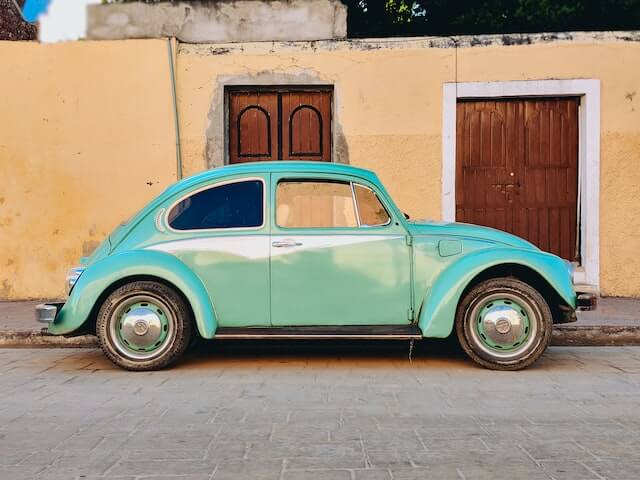

In [ ]:
url = 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true'
image = Image.open(requests.get(url, stream=True).raw)
image


#### CPU

In [ ]:
model_id = 'google/paligemma-3b-mix-224'
# model_id = 'google/paligemma-3b-mix-448'

model = PaliGemmaForConditionalGeneration.from_pretrained(model_id).eval()
model.device


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

device(type='cpu')

In [ ]:
processor = AutoProcessor.from_pretrained(model_id)


In [ ]:
# Instruct the model to create a caption in Spanish
prompt = 'caption es'
model_inputs = processor(text=prompt, images=image, return_tensors='pt')
input_len = model_inputs['input_ids'].shape[-1]

with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    cprint(decoded)


Un auto azul estacionado frente a un edificio.

In [ ]:
del model
import gc
gc.collect();


#### GPU

In [ ]:
model_id = 'google/paligemma-3b-mix-224'
device = DEVICE
dtype = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision='bfloat16',
).eval()
model.device


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

device(type='mps', index=0)

In [ ]:
# Instruct the model to create a caption in Spanish
prompt = 'caption es'
model_inputs = processor(text=prompt, images=image, return_tensors='pt').to(model.device)
input_len = model_inputs['input_ids'].shape[-1]

with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)


Un auto azul estacionado frente a un edificio.


In [ ]:
del model
torch.cuda.empty_cache()
import gc
gc.collect();


## Mac

### OCR

In [ ]:
if IN_MAC:
    model_path = 'mlx-community/paligemma-3b-mix-224-8bit'
    # model_path = 'mlx-community/paligemma-3b-mix-448-8bit'
    model, processor = load(model_path)


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
prompt = 'What does the text say?'
prompt = 'OCR the text in the image'
cprint(repr(prompt))


'OCR the text in the image'

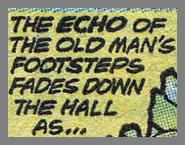

In [ ]:
image_url = Path('../experiment/cache/Strange_Tales_172005/_crop/Strange_Tales_172005_7_Default, grey pad.png')
image1 = Image.open(image_url)
display(image1)


In [ ]:
if IN_MAC:
    output = generate(
        model, 
        processor,  # type: ignore
        image1,  # type: ignore
        prompt,  # type: ignore
        max_tokens=100,
        temp=0.0,
        top_p=1.0,
        # repetition_penalty=1.2,
        verbose=True
    )


Image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=185x145> 

Prompt: OCR the text in the image
THE ECHO OF THE OLD MAN'S FOOTSTEPS FADES DOWN THE HALL AS...
Prompt: 20.769 tokens-per-sec
Generation: 62.188 tokens-per-sec


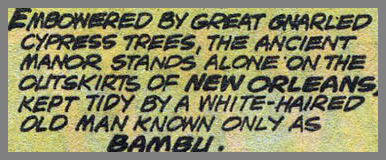

In [ ]:
image_url = Path('../experiment/cache/Strange_Tales_172005/_crop/Strange_Tales_172005_0_Default, grey pad.png')
image2 = Image.open(image_url)
display(image2)


In [ ]:
if IN_MAC:
    output = generate(
        model, 
        processor,  # type: ignore
        image2,  # type: ignore
        prompt,  # type: ignore
        max_tokens=100,
        temp=0.0,
        top_p=1.0,
        # repetition_penalty=1.2,
        # repetition_context_size=40,
        verbose=True
    )


Image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=386x160> 

Prompt: OCR the text in the image
EMBOWERED BY GREAT CHARLED CYPRESS TREES, THE ANCIENT MAYOR STANDS ALONE ON THE OUTSKIRTS OF NEW ORLEANS, KEPT TIDY BY A WHITE-HAIRED OLD MAN KNOWN ONLY AS BAMBU.
Prompt: 23.426 tokens-per-sec
Generation: 62.838 tokens-per-sec


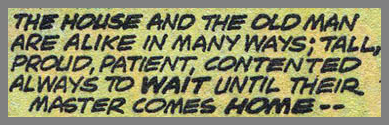

In [ ]:
image_url = Path('../experiment/cache/Strange_Tales_172005/_crop/Strange_Tales_172005_1_Default, grey pad.png')
image3 = Image.open(image_url)
display(image3)


In [ ]:
if IN_MAC:
    output = generate(
        model, 
        processor,  # type: ignore
        image3,  # type: ignore
        prompt,  # type: ignore
        max_tokens=100,
        temp=0.0,
        top_p=1.0,
        # repetition_penalty=1.2,
        # repetition_context_size=40,
        verbose=True
    )


Image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=389x125> 

Prompt: OCR the text in the image
THE HOUSE AND THE OLD MAN ARE ALIKE IN MANY WAYS; TALL, PROUD, PATIENT, CONTENTED ALWAYS TO WAIT UNTIL THEIR MASTER COMES HOME--
Prompt: 23.533 tokens-per-sec
Generation: 62.826 tokens-per-sec


In [ ]:
if IN_MAC:
    del processor
    del model
    mx.metal.clear_cache()
    import gc
    gc.collect()
    

## Linux

### [Model card](https://huggingface.co/google/paligemma-3b-mix-448) examples

#### 4-bit/8-bit

In [ ]:
if IN_LINUX:
    model_id = "google/paligemma-3b-mix-224"
    device = "cuda:0"
    dtype = torch.bfloat16

    quantization_config = BitsAndBytesConfig(load_in_8bit=True)

    model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id, quantization_config=quantization_config
    ).eval()
    model.device


In [ ]:
if IN_LINUX:
    # Instruct the model to create a caption in Spanish
    prompt = "caption es"
    model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
    input_len = model_inputs["input_ids"].shape[-1]

    with torch.inference_mode():
        generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
        generation = generation[0][input_len:]
        decoded = processor.decode(generation, skip_special_tokens=True)
        print(decoded)


In [ ]:
if IN_LINUX:
    del model
    torch.cuda.empty_cache()
    import gc
    gc.collect();


### OCR

In [ ]:
processor = AutoProcessor.from_pretrained(model_id)


In [ ]:
model_id = "google/paligemma-3b-mix-224"
device = DEVICE#"cuda:0"
dtype = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
).eval()
model.device


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

device(type='mps', index=0)

In [ ]:
# prompt = "OCR"
# prompt = (
#         "Do perform optical character recognition OCR on the image, which contains speech "
#         "balloons from a comic book. The text is in English. Carefully extract the text exactly "
#         "as it appears, ensuring that you preserve the original capitalization, punctuation, and "
#         "formatting."
# )

# # prompt = 'What does the text say?'
prompt = 'OCR the text in the image'

model_inputs = processor(text=prompt, images=image3, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)


THE HOUSE AND THE OLD MAN ARE ALIKE IN MANY WAYS; TALL, PROUD, PATIENT, CONTENTED ALWAYS TO WAIT UNTIL THEIR MASTER COMES HOME --


In [ ]:
del processor
del model
if IN_LINUX:
    torch.cuda.empty_cache()
if IN_MAC:
    mx.metal.clear_cache()
import gc
gc.collect()


60

----
# PaliGemma experiments


# Experiment directory

In [ ]:
EXP_DIR = "../experiment"


# Setup ngrok (Colab)

The experiments can generate hundreds of images, and maintaining the **PIL** images in memory is not efficient. All the generated images are cached and visualized on demand through a URL pointing to the local cache. This approach prevents the kernel from being overloaded with **PIL** images, with the front-end responsible for fetching the image and the backend web server (not the kernel) for serving the image in another process. This method is quick and efficient. As an added bonus, the saved notebook remains lean and fit; it doesn't store the Base64 versions of all the output cell images.

Unfortunately, this approach does not work as is in **Colab**. Google Colab runs on an older Ubuntu 18.04 VM, so all the usual networking challenges with Docker, or whatever VMs Google is using, apply. Google also goes to great lengths to avoid exposing its internal architecture. We have two options:
- Let the Jupyter kernel serve the images itself, which is slow and memory-consuming.
- Use a tunnel to map localhost (server) to whatever IP and port the front-end (the browser you're currently using) is running on. We can use **ngrok** for this, but *ngrok* is a commercial service that has been abused and now requires confirmation the first time the tunnel connects, which can be inconvenient for the user. It also requires the user to open a free account and obtain an auth token.

You choose.

If the notebook is running in Colab and ngrok has been successfully installed and the tunnel has been created, the default setting is USE_PIL=False. You can set the environment variable USE_PIL=True to force the use of PIL images, but note that in certain circumstances, Colab will complain because the free tiers are usually memory constrained.


In [ ]:
if 'USE_TUNNEL' not in os.environ:
    os.environ['USE_TUNNEL'] = 'True' if FC.IN_COLAB else 'False'
if 'USE_PIL' not in os.environ:
    os.environ['USE_PIL'] = 'True' if FC.IN_COLAB and os.environ['USE_TUNNEL'] == 'False' else 'False'


In [ ]:
SERVER = None
if (os.environ['USE_PIL'].lower() == 'false') and os.environ['USE_TUNNEL'].lower() == 'true':
    SERVER = setup_ngrok(WebServerBottle, Path(EXP_DIR))


# PaliGemma initialization

## Processor

In [ ]:
#| exporti

SizeT = Literal['224', '448']
QuantT: TypeAlias = Literal['bfloat16'] | Literal['8bit'] | Literal['4bit']


def _setup_processor(model_id: str='google/paligemma-3b-mix-224', **kwargs):
    size: SizeT = kwargs.pop('size', '224')
    quant: QuantT = kwargs.pop('quant', '8bit')
    if IN_MAC and quant != 'bfloat16':
        from mlx_vlm.utils import get_model_path, load_processor
        model_id = f'mlx-community/paligemma-3b-mix-{size}-8bit'
        processor_config = kwargs.pop('processor_config', None)
        model_path = get_model_path(model_id)
        if processor_config is None:
            processor = load_processor(model_path)
        else:
            processor = load_processor(model_path, processor_config=processor_config)
    else:
        processor = AutoProcessor.from_pretrained(model_id)
    return processor


## Model loading


In [ ]:
#| exporti

def _setup_model(device:str | None, size: SizeT, quant: QuantT, lazy: bool = False):
    if IN_MAC and quant != 'bfloat16':
        from mlx_vlm.utils import load_model, get_model_path
        model_id = f"mlx-community/paligemma-3b-mix-{size}-8bit"
        model_path = get_model_path(model_id)
        model = load_model(model_path, lazy=lazy)
    else:
        model_id = f"google/paligemma-3b-mix-{size}"
        generation_args: dict =  {
        }
        if quant == '8bit':
            generation_args['quantization_config'] = BitsAndBytesConfig(load_in_8bit=True)
        elif quant =='4bit':
            generation_args['quantization_config'] = BitsAndBytesConfig(load_in_4bit=True)
        else:
            generation_args['device_map'] = device or default_device()
            generation_args['torch_dtype'] = torch.bfloat16
            generation_args['revision'] = 'bfloat16'
        model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, **generation_args,).eval()

    return model

# PaliGemmaOCR

In [ ]:
#| exporti


prompt_text_tmpl = (
        "Perform optical character recognition OCR on this image, which contains speech "
        "balloons from a comic book. The text is in {}."
)

prompt_text_tmpl = (
        "Do perform optical character recognition OCR on the image, which contains speech "
        "balloons from a comic book. The text is in {}. Carefully extract the text exactly "
        "as it appears, ensuring that you preserve the original capitalization, punctuation, and "
        "formatting."
)

prompt_text_tmpl = 'What does the text say?'
prompt_text_tmpl = 'OCR the text in the image'


default_prompt_text_tmpl = prompt_text_tmpl

In [ ]:
#| export

class PaliGemmaOCR:
    prompt_text_tmpl: str = default_prompt_text_tmpl
    PROCESSOR: Any = None
    MODEL: Any = None


    @classmethod
    def setup_processor(cls, 
            model_id: str='google/paligemma-3b-mix-224', 
            size: SizeT = '224',
            quant: QuantT = '8bit',
            ):
        cls.PROCESSOR = _setup_processor(model_id, size=size, quant=quant)
        return cls.PROCESSOR
    
    @classmethod
    def setup_model(cls, device: str | None = None, size: SizeT='224', quant: QuantT='bfloat16'):
        cls.MODEL = _setup_model(device, size, quant)
        return cls.MODEL
    
    @staticmethod
    def is_paligemma_available() -> bool:
        return PaliGemmaOCR.PROCESSOR is not None and PaliGemmaOCR.MODEL is not None
    is_model_ready = is_paligemma_available

    def setup_paligemma(self):
        if self.PROCESSOR is None:
            type(self).setup_processor(size=self.size, quant=self.quant)
        if self.MODEL is None:
            type(self).setup_model(self.device, self.size, self.quant)
    setup = setup_paligemma
    
    def cleanup(self):
        try: del self.PROCESSOR
        except Exception: pass
        try: del self.MODEL
        except Exception: pass
        if IN_MAC:
            mx.metal.clear_cache()
        else:
            torch.cuda.empty_cache()
        import gc
        gc.collect()
        self.MODEL = self.PROCESSOR = None

    def _generation_args_mac(self, image: Image.Image, prompt_text: str):
        prompt = prompt_text
        max_new_tokens = 100
        temperature = 0.0
        top_p = 1.0
        # repetition_penalty = 1.2
        # repetition_context_size = 20
        generation_args: dict = {
            'model': self.MODEL,
            'processor': self.PROCESSOR,
            "image": image,
            'prompt': prompt,
            "max_tokens": max_new_tokens,
            'temp': temperature,
            'top_p': top_p,
            # 'repetition_penalty': repetition_penalty,
            # 'repetition_context_size': repetition_context_size,
        }
        return prompt, generation_args

    def _generation_args(self, image: Image.Image, prompt: str):
        model_inputs = self.PROCESSOR(text=prompt, images=image, return_tensors="pt").to(self.MODEL.device)
        max_new_tokens=100
        do_sample = False
        generation_args: dict = {
            'max_new_tokens': max_new_tokens,
            'do_sample': do_sample,
        }
        return prompt, model_inputs, generation_args

    def _generate_mac(self, image: Image.Image, prompt_text: str):
        prompt, generation_args = self._generation_args_mac(image, prompt_text)
        output = generate(
            **generation_args, 
            verbose=False#True
        )
        return prompt, output.strip('<end_of_utterance>').strip(' ')

    def _generate(self, image: Image.Image, prompt: str):
        prompt, model_inputs, generation_args = self._generation_args(image, prompt)
        input_len = model_inputs["input_ids"].shape[-1]
        with torch.inference_mode():
            generation = self.MODEL.generate(**model_inputs, **generation_args)
            generation = generation[0][input_len:]
            decoded = self.PROCESSOR.decode(generation, skip_special_tokens=True)
        return prompt, decoded

    def postprocess_ocr(self, text):
        return ' '.join(remove_multiple_whitespaces(text).splitlines())
    
    def show_info(self):
        quant = self.quant
        size = self.size
        cfg = PaliGemmaOCR.MODEL.config if PaliGemmaOCR.MODEL is not None else None
        if cfg is not None:
            if hasattr(cfg, 'quantization_config'):
                qcfg = cfg.quantization_config
                quant = '4bit' if qcfg.load_in_4bit else '8bit'
        cprint(
            f"{'Size':>17}: {size!r}\n"
            f"{'Quantization':>17}: {quant!r}\n"
            f"{'Device':>17}: {self.device!r}\n"
            f"{'VRAM':>17}: {get_gpu_vram(False)}/{get_gpu_vram()} MiB\n"
        )


    def __call__(
        self,
        img_or_path: Image.Image | Path | str,
        lang: str | None = None,
        prompt_text: str | None = None,
        config: str | None = None,
        show_prompt: bool = False,
        **kwargs,
    ) -> str:
        self.setup_paligemma()
        if not self.is_paligemma_available():
            raise RuntimeError("PaliGemma is not installed or not found.")
        prompt_text = prompt_text or self.prompt_text_tmpl.format(lang or self.lang)
        image = load_image(img_or_path)
        gen_func = self._generate_mac if IN_MAC and self.quant != 'bfloat16' else self._generate
        prompt, generated_text = gen_func(image, prompt_text)
        if show_prompt:
            cprint("INPUT:", prompt, "\nOUTPUT:", generated_text)
        return generated_text#.strip('"')


    def __init__(self, 
            lang: str | None = None, 
            size: SizeT | None = None,
            quant: QuantT | None = None,
            device: str | None = None, 
            *, 
            prompt_text_tmpl: str | None = None, 
            lazy: bool | None = False,
            **_
        ):
        self.lang = lang
        self.prompt_text_tmpl = prompt_text_tmpl or self.prompt_text_tmpl
        self.size: SizeT = size or '224'
        self.quant: QuantT = quant or 'bfloat16'#'8bits'
        self.device = device or default_device()
        if not lazy and not self.is_paligemma_available():
            self.setup_paligemma()


OCRExperimentContext.register_model('PaliGemma', PaliGemmaOCR, {
            "size": '224',
            "quant": 'bfloat16',
        })


# Context

| quant \ platform | Mem   | Mac  | Linux | Windows | Colab T4 | Colab L4/H100 |
| ---              | ---   | ---  | ---   | ---     | ---      | ---           |
| **bfloat16**     |  6 GB | ✅   | ✅    | ?       | ✅       | ✅            |
| **8bit**         |  3 GB | ✅   | ✅    | ?       | ✅       | ✅            |
| **4bit**         |  2 GB | ✅   | ✅    | ?       | ✅       | ✅            |


In [ ]:
try: CONTEXT.cleanup_model()  # type: ignore
except: pass

quant = '4bit'
# quant = '8bit'
# quant = 'bfloat16'
CONTEXT = OCRExperimentContext('PaliGemma', EXP_DIR, quant=quant, load=False)
CONTEXT.show()


Current Configuration:

Locale: System default
Default Profile: Built-in
Saved Profiles:
- victess: /Users/vic/dev/repo/DL-mac/cleaned/victess.conf
- vicmang: /Users/vic/dev/repo/DL-mac/cleaned/vicmang.conf

Profile Editor: cursor
Cache Directory: System default
Default Torch Model Path: /Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt
Default CV2 Model Path: /Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt.onnx
GUI Theme: System default

--------------------

Config file located at: /Users/vic/Library/Application Support/pcleaner/pcleanerconfig.ini
System default cache directory: /Users/vic/Library/Caches/pcleaner


config cache_dir: None
       model_path: Path('/Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt')
           device: 'mps'

force_PIL: False
       use_tunnel: False
       server_url: 
   experiment dir: ../experiment
       source_dir: ../experiment/source
        cache_dir: ../experiment/cache

Experiment runs:
PaliGemma-crop-post: 0

In [ ]:
ocr_model = CONTEXT.setup_ocr_model(False)
ocr_model.show_info()

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Size: '224'
     Quantization: '4bit'
           Device: 'mps'
             VRAM: 2986/65536 MiB

In [ ]:
CONTEXT.reset_results(image_idx=20)
result = CONTEXT.result('PaliGemma-crop', 20, 0, CropMethod.DEFAULT_GREY_PAD)
result


,"Embowered by great charled cypress trees, the ancient mayor stands alone on the outskirts of new orleans, kept tidy by a white-haired old man known only as bambu.0.96"


In [ ]:
CONTEXT.result('Paligemma', 20, 7, CropMethod.INITIAL_BOX)

,The echo of the old man's footsteps fades down the hall as...1.00


In [ ]:
CONTEXT.result('Paligemma', 20, 1, CropMethod.DEFAULT)

,"The house and the old man are alike in many ways, tall, proud, patient, contented always to wait until their master comes home--0.99"


# Test images


In [ ]:
IMAGE_PATHS = CONTEXT.image_paths

[f"{i:02}: {_.name}" for i,_ in enumerate(IMAGE_PATHS)]


['00: Action_Comics_1960-01-00_(262).JPG',
 '01: Adolf_Cap_01_008.jpg',
 '02: Barnaby_v1-028.png',
 '03: Barnaby_v1-029.png',
 '04: Buck_Danny_-_12_-_Avions_Sans_Pilotes_-_013.jpg',
 '05: Cannon-292.jpg',
 '06: Contrato_con_Dios_028.jpg',
 '07: Erase_una_vez_en_Francia_02_88.jpg',
 '08: FOX_CHILLINTALES_T17_012.jpg',
 '09: Furari_-_Jiro_Taniguchi_selma_056.jpg',
 '10: Galactus_12.jpg',
 '11: INOUE_KYOUMEN_002.png',
 '12: MCCALL_ROBINHOOD_T31_010.jpg',
 '13: MCCAY_LITTLENEMO_090.jpg',
 '14: Mary_Perkins_On_Stage_v2006_1_-_P00068.jpg',
 '15: PIKE_BOYLOVEGIRLS_T41_012.jpg',
 '16: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_1.png',
 '17: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_1_K.png',
 '18: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_2.png',
 '19: Spirou_Et_Fantasio_Integrale_06_1958_1959_0025_0024.jpg',
 '20: Strange_Tales_172005.jpg',
 '21: Strange_Tales_172021.jpg',
 '22: Tarzan_014-21.JPG',
 '23: Tintin_21_Les_Bijoux_de_la_Castafiore_page_39.jp

# EXP_RUN

In [ ]:
EXP_RUN = CONTEXT.experiment_run()
assert EXP_RUN is not None
RUN_NAME = EXP_RUN.name
RUN_NAME


'PaliGemma-crop-post'

# Base image


In [ ]:
BASE_IMAGE_IDX: ImgIdT = cast(ImgIdT, CONTEXT.normalize_idx("Strange_Tales_172005.jpg"))

assert BASE_IMAGE_IDX is not None
img_path = CONTEXT.final(CONTEXT.image_paths[BASE_IMAGE_IDX])
assert img_path.exists()

img_visor = ImageContextVisor(CONTEXT, BASE_IMAGE_IDX)
img_visor


In [ ]:
page_lang = 'English'

IMAGE_CONTEXT = ImageContext(CONTEXT, BASE_IMAGE_IDX, page_lang=page_lang)
test_eq(IMAGE_CONTEXT.page_data is not None, True)
RenderJSON(IMAGE_CONTEXT.json_data, 360, 2)


# Box id


In [ ]:
BOX_IDX = 0

### Crop methods

In [ ]:
image_experiment = ExperimentOCR.from_image(CONTEXT, RUN_NAME, IMAGE_CONTEXT.image_idx)


In [ ]:
method = CropMethod.INITIAL_BOX

result = image_experiment.result(BOX_IDX, method, ocr=False)
assert result is not None

image = result.image
assert image is not None
text = CONTEXT.ocr_model(image, lang=page_lang)
result.ocr = postprocess_ocr(text)
result


,"Embohered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tidy by a white-haired old man known only as bambu.0.98"


In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_4)

,"Embohered by great charled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tidy by a white-haired old man known only as bambu.0.96"


In [ ]:
image_experiment.result(BOX_IDX, CropMethod.PAD_8_FRACT_0_2)

,,


----
# Visualize results

In [ ]:
CONTEXT.reset_results(image_idx=20)
result_visor = ResultVisor(image_experiment)
result_visor


----
# Visualize Experiment

In [ ]:
exp_visor = ExperimentVisor(image_experiment)
exp_visor


----
# EEAaO

In [ ]:
idefics_experiment = ExperimentsVisor(
                        CONTEXT, 
                        'PaliGemma', 
                        image_idx=BASE_IMAGE_IDX, 
                        box_idx=13, 
                        method=CropMethod.DEFAULT_GREY_PAD
                    )
idefics_experiment


----

In [ ]:
CONTEXT.cleanup_model()

if SERVER is not None:
    SERVER.stop()
    SERVER = None
    os.environ['USE_TUNNEL'] = 'False'


# Colophon
----


In [ ]:
import fastcore.all as FC
from nbdev.export import nb_export


In [ ]:
if FC.IN_NOTEBOOK:
    nb_export('ocr_paligemma.ipynb', '../testbed')
